In [1]:
!pip install category_encoders


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 922.2 kB/s eta 0:00:00


In [3]:
pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 2.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import category_encoders as ce
import seaborn as sns
import statsmodels.api as sm
import joblib
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import shap
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense


In [57]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name, encoding='latin1')
data.head()

Saving 2005-2024-fuel-consumption-ratings-5-cycle.csv to 2005-2024-fuel-consumption-ratings-5-cycle (3).csv


,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2005,Acura,1.7EL,Compact,1.7,4,A4,X,9.2,7.2,8.3,34,191,NaN,NaN
1,2005,Acura,1.7EL,Compact,1.7,4,M5,X,9.1,7.3,8.3,34,191,NaN,NaN
2,2005,Acura,MDX AWD,Sport utility vehicle,3.5,6,A5,Z,15.9,11.1,13.7,21,315,NaN,NaN
3,2005,Acura,NSX,Two-seater,3.0,6,AS4,Z,15.1,10.5,13.0,22,299,NaN,NaN
4,2005,Acura,NSX,Two-seater,3.2,6,M6,Z,15.1,10.5,13.0,22,299,NaN,NaN


In [58]:
#removing unnecessary cols
# Drop the 'Smog rating' column from the DataFrame
data.drop('Smog rating', axis=1, inplace=True)


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model year            20491 non-null  int64  
 1   Make                  20491 non-null  object 
 2   Model                 20491 non-null  object 
 3   Vehicle class         20491 non-null  object 
 4   Engine size (L)       20491 non-null  float64
 5   Cylinders             20491 non-null  int64  
 6   Transmission          20491 non-null  object 
 7   Fuel type             20491 non-null  object 
 8   City (L/100 km)       20491 non-null  float64
 9   Highway (L/100 km)    20491 non-null  float64
 10  Combined (L/100 km)   20491 non-null  float64
 11  Combined (mpg)        20491 non-null  int64  
 12  CO2 emissions (g/km)  20491 non-null  int64  
 13  CO2 rating            8802 non-null   float64
dtypes: float64(5), int64(4), object(5)
memory usage: 2.2+ MB


# **EDA**

In [60]:
# Filter the DataFrame to get data from 2016 to 2024
data_2016_to_2024 = data[data['Model year'].between(2016, 2024)]
data_2016_to_2024.head()


,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating
11689,2016,Acura,ILX,Compact,2.4,4,AM8,Z,9.3,6.6,8.1,35,189,7.0
11690,2016,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6,AS9,Z,12.7,9.1,11.1,25,254,5.0
11691,2016,Acura,MDX SH-AWD Elite,Sport utility vehicle: Small,3.5,6,AS9,Z,12.2,9.1,10.7,26,251,5.0
11692,2016,Acura,RDX AWD,Sport utility vehicle: Small,3.5,6,AS6,Z,12.4,8.6,10.7,26,249,5.0
11693,2016,Acura,RLX,Mid-size,3.5,6,AS6,Z,11.9,7.7,10.0,28,235,5.0


In [61]:
# Count the occurrences of each unique value in the CO2 rating column, including NaN values
co2_rating_counts = data_2016_to_2024['CO2 rating'].value_counts(dropna=False)

# Display the counts
print(co2_rating_counts)



CO2 rating
5.0     2380
4.0     2132
3.0     1464
6.0     1143
7.0      718
2.0      463
8.0      206
1.0      157
9.0       87
10.0      52
Name: count, dtype: int64


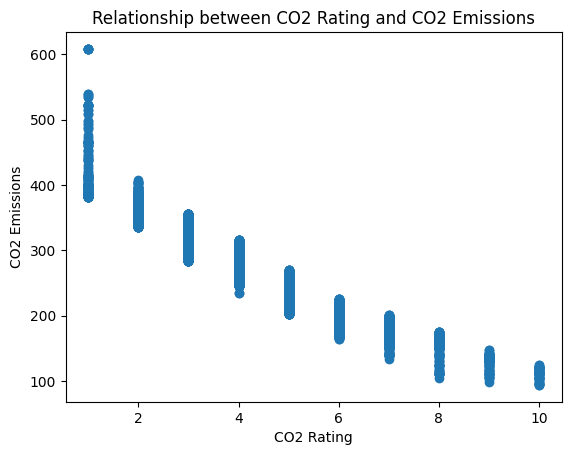

In [62]:
plt.scatter(data_2016_to_2024['CO2 rating'], data_2016_to_2024['CO2 emissions (g/km)'])
plt.xlabel('CO2 Rating')
plt.ylabel('CO2 Emissions')
plt.title('Relationship between CO2 Rating and CO2 Emissions')
plt.show()


In [63]:
# Group the data by 'CO2 rating' and calculate the range of 'CO2 emissions (g/km)' for each group
co2_rating_range = data_2016_to_2024.groupby('CO2 rating')['CO2 emissions (g/km)'].agg(['min', 'max'])

# Print the range of 'CO2 emissions (g/km)' for each CO2 rating value
print(co2_rating_range)


            min  max
CO2 rating          
1.0         381  608
2.0         336  408
3.0         284  356
4.0         234  316
5.0         202  270
6.0         165  226
7.0         133  201
8.0         104  175
9.0          99  147
10.0         94  124


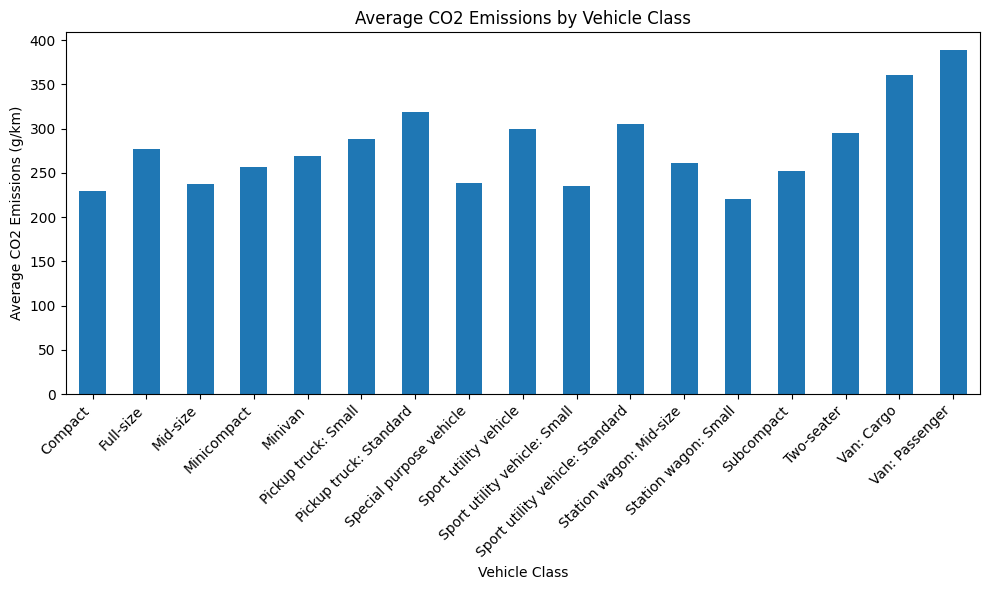

In [64]:
# Group the data by 'Vehicle class' and calculate the average 'CO2 emissions (g/km)' for each group
average_co2_emissions = data.groupby('Vehicle class')['CO2 emissions (g/km)'].mean()

# Plot the average CO2 emissions for each vehicle class
plt.figure(figsize=(10, 6))
average_co2_emissions.plot(kind='bar')
plt.xlabel('Vehicle Class')
plt.ylabel('Average CO2 Emissions (g/km)')
plt.title('Average CO2 Emissions by Vehicle Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


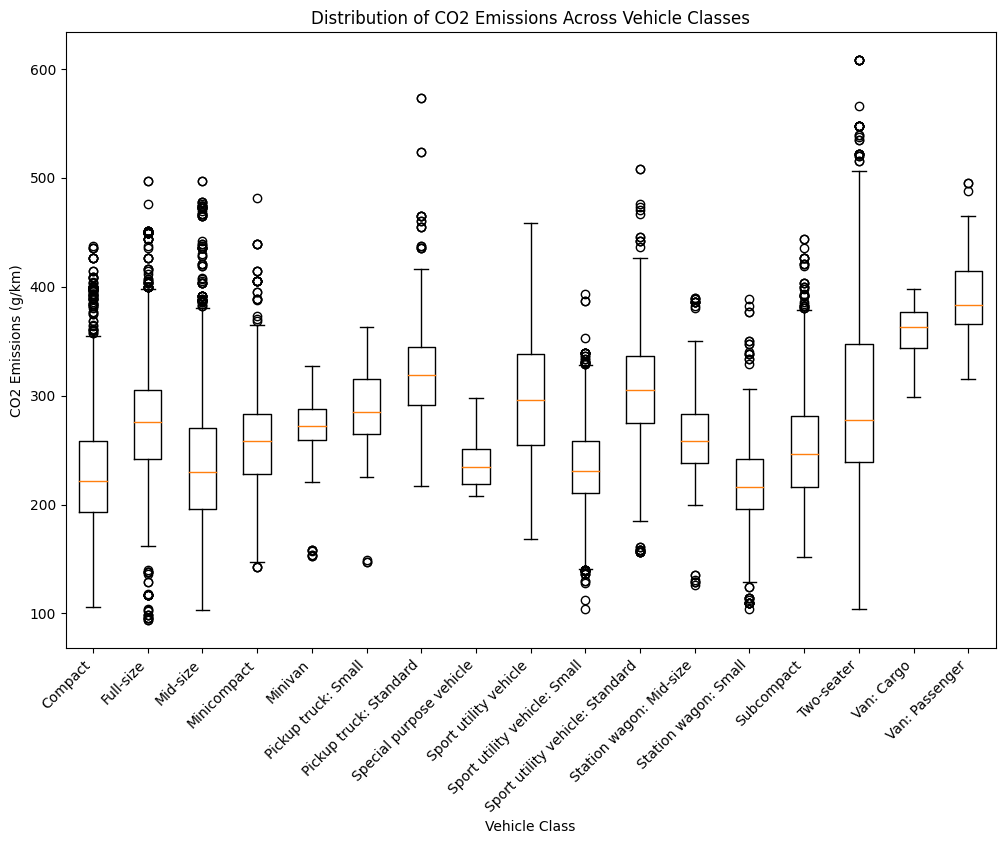

In [67]:

# Group the data by 'Vehicle class' and extract CO2 emissions for each group
grouped_data = data.groupby('Vehicle class')['CO2 emissions (g/km)'].apply(list)

# Create a box plot
plt.figure(figsize=(12, 8))
plt.boxplot(grouped_data.values, labels=grouped_data.index)
plt.xlabel('Vehicle Class')
plt.ylabel('CO2 Emissions (g/km)')
plt.title('Distribution of CO2 Emissions Across Vehicle Classes')
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.show()


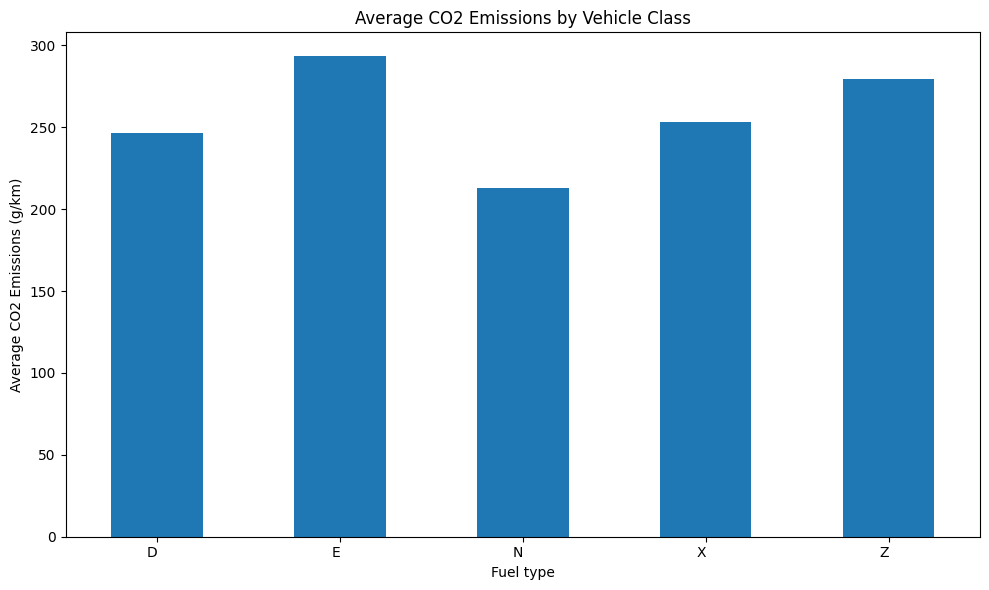

In [68]:


# Group the data by 'Vehicle class' and calculate the average 'CO2 emissions (g/km)' for each group
average_co2_emissions = data.groupby('Fuel type')['CO2 emissions (g/km)'].mean()

# Plot the average CO2 emissions for each vehicle class
plt.figure(figsize=(10, 6))
average_co2_emissions.plot(kind='bar')
plt.xlabel('Fuel type')
plt.ylabel('Average CO2 Emissions (g/km)')
plt.title('Average CO2 Emissions by Vehicle Class')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()


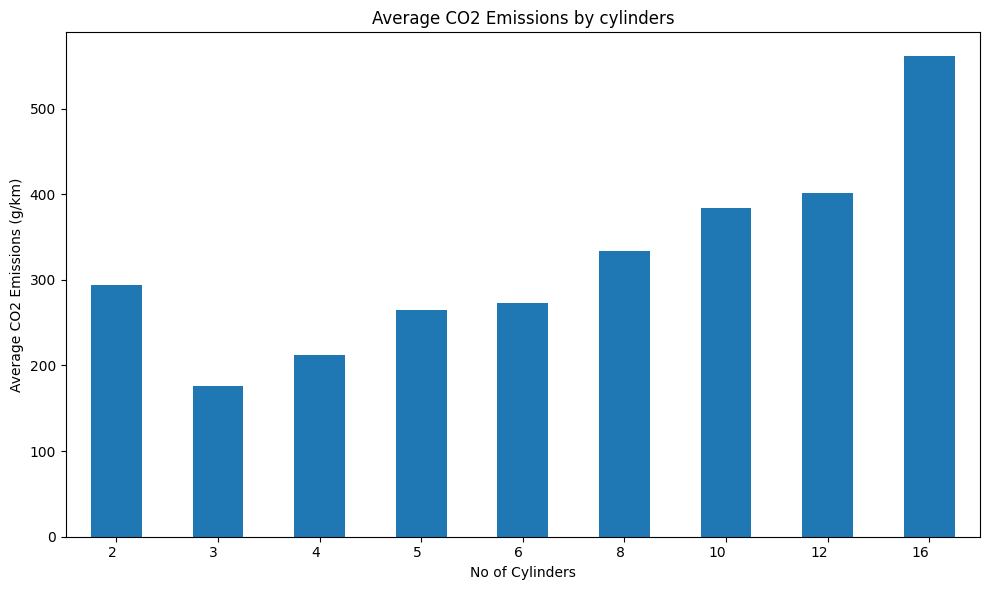

In [69]:


# Group the data by 'Vehicle class' and calculate the average 'CO2 emissions (g/km)' for each group
average_co2_emissions = data.groupby('Cylinders')['CO2 emissions (g/km)'].mean()

# Plot the average CO2 emissions for each vehicle class
plt.figure(figsize=(10, 6))
average_co2_emissions.plot(kind='bar')
plt.xlabel('No of Cylinders')
plt.ylabel('Average CO2 Emissions (g/km)')
plt.title('Average CO2 Emissions by cylinders')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()


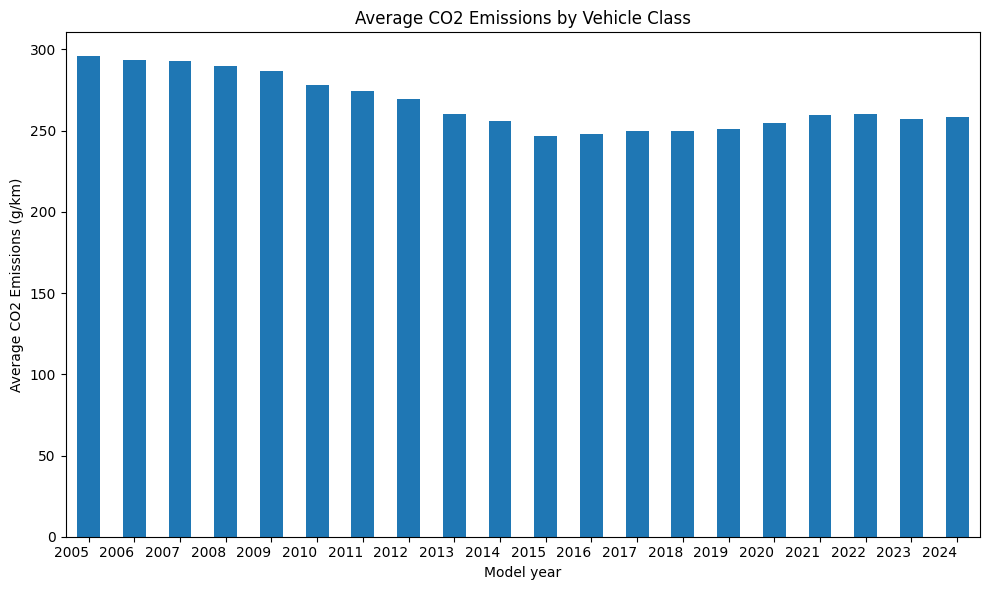

In [70]:


# Group the data by 'Vehicle class' and calculate the average 'CO2 emissions (g/km)' for each group
average_co2_emissions = data.groupby('Model year')['CO2 emissions (g/km)'].mean()

# Plot the average CO2 emissions for each vehicle class
plt.figure(figsize=(10, 6))
average_co2_emissions.plot(kind='bar')
plt.xlabel('Model year')
plt.ylabel('Average CO2 Emissions (g/km)')
plt.title('Average CO2 Emissions by Vehicle Class')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()


### Hypothesis Tests

In [71]:

def kruskal_wallis_test(data, column, co2_emissions_column):
    """
    Perform Kruskal-Wallis H test to compare CO2 emissions across different groups in a column.

    Args:
    - data: DataFrame containing the dataset
    - column: Column name for the categorical variable to group by
    - co2_emissions_column: Column name for CO2 emissions

    Returns:
    - Tuple containing the H statistic and p-value
    """
    groups = []
    for group_name, group_data in data.groupby(column):
        groups.append(group_data[co2_emissions_column])
    return kruskal(*groups)



In [72]:

result = kruskal_wallis_test(data, 'Fuel type', 'CO2 emissions (g/km)')
print("H statistic:", result.statistic)
print("p-value:", result.pvalue)


H statistic: 999.6129240462217
p-value: 4.3299357073297066e-215


 there are statistically significant differences in CO2 emissions between the "Fuel types"

In [73]:
result = kruskal_wallis_test(data, 'Make', 'CO2 emissions (g/km)')
print("H statistic:", result.statistic)
print("p-value:", result.pvalue)

H statistic: 6926.284651211539
p-value: 0.0


 there are statistically significant differences in CO2 emissions between the "Make"

In [74]:
result = kruskal_wallis_test(data, 'Model year', 'CO2 emissions (g/km)')
print("H statistic:", result.statistic)
print("p-value:", result.pvalue)

H statistic: 1445.6477308840813
p-value: 2.050581642228293e-295


There is no statistical difference due to "Model year" i.e the company designated manufacturing year.

### Encoding Categorical Variables

In [75]:
# Specify the columns to be target encoded
cat_cols = ['Make', 'Fuel type', 'Transmission','Model','Vehicle class']

# Initialize the target encoder
target_encoder = ce.TargetEncoder(cols=cat_cols)

# Fit the target encoder to the data
target_encoder.fit(data[cat_cols], data['CO2 emissions (g/km)'])

# Transform the categorical columns using target encoding
data_encoded = target_encoder.transform(data[cat_cols])

# Replace the original categorical columns with the encoded columns
data.drop(cat_cols, axis=1, inplace=True)
data_encoded.columns = [col + '_encoded' for col in data_encoded.columns]
data = pd.concat([data, data_encoded], axis=1)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# OLS Report

In [79]:

# Define the independent variables (features) excluding non-numeric columns
independent_vars = ['Model year', 'Engine size (L)', 'Cylinders', 'City (L/100 km)',
                    'Highway (L/100 km)', 'Make_encoded', 'Fuel type_encoded',
                    'Transmission_encoded', 'Combined (L/100 km)', 'Combined (mpg)',
                    'Model_encoded', 'Vehicle class_encoded']


# Extract the independent variables (X) and dependent variable (y)
X = data[independent_vars]
y = data['CO2 emissions (g/km)']

# Add a constant term to the independent variables to represent the intercept
X = sm.add_constant(X)

# Fit the OLS regression model
ols_model = sm.OLS(y, X).fit()

# Print the regression results summary
print(ols_model.summary())

                             OLS Regression Results                             
Dep. Variable:     CO2 emissions (g/km)   R-squared:                       0.919
Model:                              OLS   Adj. R-squared:                  0.919
Method:                   Least Squares   F-statistic:                 1.928e+04
Date:                  Fri, 26 Apr 2024   Prob (F-statistic):               0.00
Time:                          22:04:03   Log-Likelihood:                -88422.
No. Observations:                 20491   AIC:                         1.769e+05
Df Residuals:                     20478   BIC:                         1.770e+05
Df Model:                            12                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

# Correlation Matrix

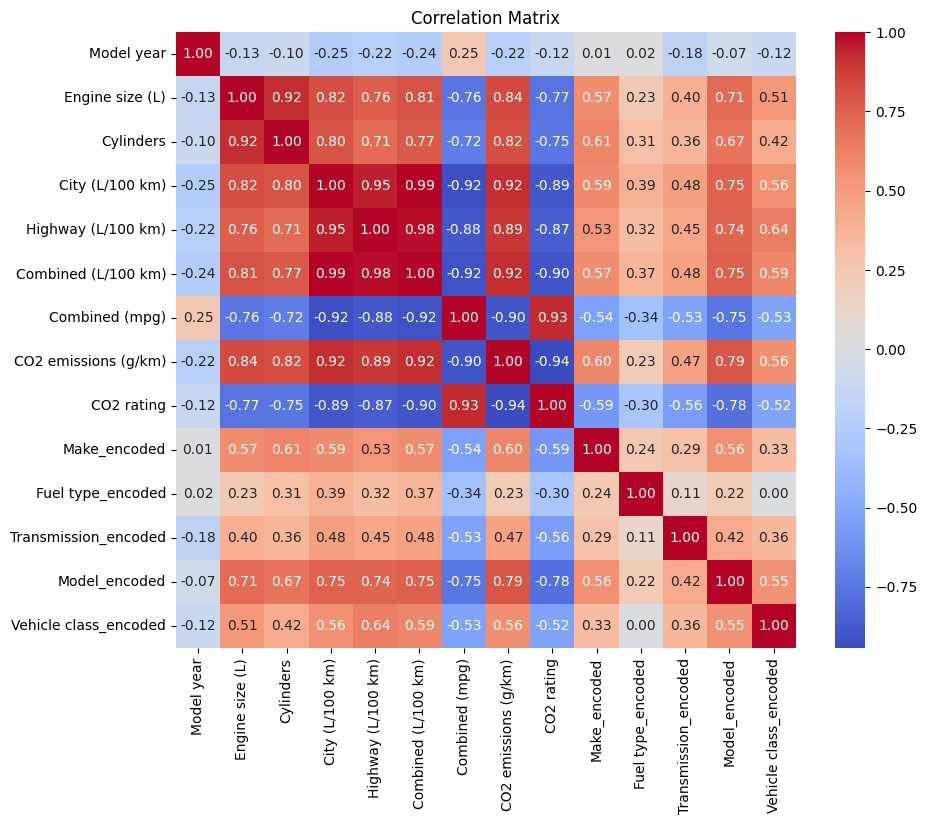

In [80]:
# Select the columns for the correlation matrix
columns = ['Model year', 'Engine size (L)', 'Cylinders', 'City (L/100 km)', 'Highway (L/100 km)',
           'Combined (L/100 km)', 'Combined (mpg)', 'CO2 emissions (g/km)', 'CO2 rating',
           'Make_encoded', 'Fuel type_encoded', 'Transmission_encoded','Model_encoded','Vehicle class_encoded']

# Calculate the correlation matrix
correlation_matrix = data[columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


# **Modelling**

In [81]:
#removing unnecessary cols # two reasons for removing 'co2 rating' one is it is highly correlated with other terms and other is it as too many null values from 2005-2024"
# Drop the 'CO2 rating' column from the DataFrame and store the modified DataFrame in data1
data.drop('CO2 rating', axis=1, inplace=True)



In [14]:
# Define your feature set and target variable
X = data.drop('CO2 emissions (g/km)', axis=1)
y = data['CO2 emissions (g/km)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:

# Alternatively, using joblib, which is sometimes more efficient for NumPy objects
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [16]:
# Download the file to your local machine
files.download('scaler.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Random Forest

In [83]:
# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = rf.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE: {mse}')


Test MSE: 2.27031105147597


In [84]:
# Predict on the train data
y_pred = rf.predict(X_train_scaled)

# Evaluate the model
mse = mean_squared_error(y_train, y_pred)
print(f'Train MSE: {mse}')

Train MSE: 0.30643430331869215


In [85]:
# Get feature importances
importances = rf.feature_importances_

# Convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame to find the most important features
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance_df)


                  Feature  Importance
5     Combined (L/100 km)    0.865859
6          Combined (mpg)    0.074501
8       Fuel type_encoded    0.055871
0              Model year    0.001318
4      Highway (L/100 km)    0.001215
3         City (L/100 km)    0.000591
10          Model_encoded    0.000428
7            Make_encoded    0.000081
9    Transmission_encoded    0.000045
11  Vehicle class_encoded    0.000038
1         Engine size (L)    0.000034
2               Cylinders    0.000021


#Linear Reg

In [86]:


# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 308.9956706227861


In [87]:
# Make predictions on the training data
y_pred = model.predict(X_train_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 332.56184145533985


Underfitting problem

#Gradient boosting

In [88]:

# Initialize the Gradient Boosting Regressor model
gb_regressor = GradientBoostingRegressor(random_state=42)

# Fit the model to the training data
gb_regressor.fit(X_train_scaled, y_train)

# Predict on the testing data
y_pred = gb_regressor.predict(X_test_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 7.696098013471279


In [89]:
y_pred = gb_regressor.predict(X_train_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 7.180520351905681


#SVM

In [90]:
# Initialize the SVR model
svm_regressor = SVR()

# Fit the model to the training data
svm_regressor.fit(X_train_scaled, y_train)

# Predict on the testing data
y_pred = svm_regressor.predict(X_test_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 134.29290105145463


#Neural Networks

In [91]:
# Reshape the input data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(1, X_train_scaled.shape[1])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Epoch 1/100
513/513 [==============================] - 6s 6ms/step - loss: 48411.4883
Epoch 2/100
513/513 [==============================] - 4s 8ms/step - loss: 2841.4270
Epoch 3/100
513/513 [==============================] - 6s 12ms/step - loss: 1275.0000
Epoch 4/100
513/513 [==============================] - 3s 6ms/step - loss: 1084.4034
Epoch 5/100
513/513 [==============================] - 3s 6ms/step - loss: 846.7989
Epoch 6/100
513/513 [==============================] - 4s 7ms/step - loss: 673.7531
Epoch 7/100
513/513 [==============================] - 3s 6ms/step - loss: 558.2360
Epoch 8/100
513/513 [==============================] - 2s 3ms/step - loss: 482.7852
Epoch 9/100
513/513 [==============================] - 2s 3ms/step - loss: 437.5141
Epoch 10/100
513/513 [==============================] - 2s 3ms/step - loss: 403.9944
Epoch 11/100
513/513 [==============================] - 1s 3ms/step - loss: 373.4035
Epoch 12/100
513/513 [==============================] - 2s 3ms/step 

In [92]:
#  model error on train
y_pred = model.predict(X_train_reshaped)
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Erroron train :", mse)

513/513 [==============================] - 1s 2ms/step
Mean Squared Erroron train : 5.002308438218645




1.  After modeling various machine learning techniques, it was observed that the Random Forest regressor provided the least error-prone predictions on the test data. However, it exhibited signs of overfitting. Conversely, both Gradient Boosting and Bi-directional LSTM models demonstrated better generalization to the test data.
2.  When comparing Gradient Boosting and Bi-directional LSTM, although Gradient Boosting yielded slightly higher error rates, it was preferred due to its interpretability.



Now, let's consider the business aspect of the problem. We aim to develop a model capable of predicting "CO2 emissions" based on a user's input of certain features of their vehicle. We assume that the user may not possess advanced technical knowledge about their car. Therefore, our goal is to create a model that requires only easily understandable and accessible input values from the user to predict the "CO2 emissions" from the vehicle. As a result, we will refine the modeling process to include only features that are readily available and comprehensible to the user.



Model year   
Make   
Model  
Vehicle class  
Engine size (L)  
Cylinders  
Transmission  
Fuel type  



In [20]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name, encoding='latin1')
data.head()

Saving 2005-2024-fuel-consumption-ratings-5-cycle.csv to 2005-2024-fuel-consumption-ratings-5-cycle (1).csv


,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2005,Acura,1.7EL,Compact,1.7,4,A4,X,9.2,7.2,8.3,34,191,NaN,NaN
1,2005,Acura,1.7EL,Compact,1.7,4,M5,X,9.1,7.3,8.3,34,191,NaN,NaN
2,2005,Acura,MDX AWD,Sport utility vehicle,3.5,6,A5,Z,15.9,11.1,13.7,21,315,NaN,NaN
3,2005,Acura,NSX,Two-seater,3.0,6,AS4,Z,15.1,10.5,13.0,22,299,NaN,NaN
4,2005,Acura,NSX,Two-seater,3.2,6,M6,Z,15.1,10.5,13.0,22,299,NaN,NaN


In [21]:
# Define the columns to keep
columns_to_keep = [ 'Model year', 'Make', 'Model', 'Vehicle class', 'Engine size (L)', 'Cylinders', 'Transmission', 'Fuel type','Combined (mpg)','CO2 emissions (g/km)']

# Update data to keep only the specified columns
data = data.loc[:, columns_to_keep]


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model year            20491 non-null  int64  
 1   Make                  20491 non-null  object 
 2   Model                 20491 non-null  object 
 3   Vehicle class         20491 non-null  object 
 4   Engine size (L)       20491 non-null  float64
 5   Cylinders             20491 non-null  int64  
 6   Transmission          20491 non-null  object 
 7   Fuel type             20491 non-null  object 
 8   Combined (mpg)        20491 non-null  int64  
 9   CO2 emissions (g/km)  20491 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 1.6+ MB


In [23]:
# Specify the columns to be target encoded
cat_cols = ['Make', 'Fuel type', 'Transmission','Model','Vehicle class']

# Initialize the target encoder
target_encoder = ce.TargetEncoder(cols=cat_cols)

# Fit the target encoder to the data
target_encoder.fit(data[cat_cols], data['CO2 emissions (g/km)'])

# Transform the categorical columns using target encoding
data_encoded = target_encoder.transform(data[cat_cols])

# Replace the original categorical columns with the encoded columns
data.drop(cat_cols, axis=1, inplace=True)
data_encoded.columns = [col + '_encoded' for col in data_encoded.columns]
data = pd.concat([data, data_encoded], axis=1)


In [24]:
# Save the target encoder to a file
with open('target_encoder.pkl', 'wb') as f:
    pickle.dump(target_encoder, f)
# Load the target encoder from the file
with open('target_encoder.pkl', 'rb') as f:
    target_encoder = pickle.load(f)

# Specify the path of the encoder file
encoder_path = 'target_encoder.pkl'

# Download the encoder file
files.download(encoder_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Model year             20491 non-null  int64  
 1   Engine size (L)        20491 non-null  float64
 2   Cylinders              20491 non-null  int64  
 3   Combined (mpg)         20491 non-null  int64  
 4   CO2 emissions (g/km)   20491 non-null  int64  
 5   Make_encoded           20491 non-null  float64
 6   Fuel type_encoded      20491 non-null  float64
 7   Transmission_encoded   20491 non-null  float64
 8   Model_encoded          20491 non-null  float64
 9   Vehicle class_encoded  20491 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 1.6 MB


In [26]:
# Define your feature set and target variable
X = data.drop('CO2 emissions (g/km)', axis=1)
y = data['CO2 emissions (g/km)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Serialize the scaler using pickle
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Download the scaler
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
print(X_train)

       Model year  Engine size (L)  Cylinders  Combined (mpg)  Make_encoded  \
11710        2016              2.0          4              32    264.604113   
10444        2014              2.5          4              25    235.894737   
19183        2023              2.5          4              47    273.690507   
14261        2018              2.0          4              50    273.690507   
1989         2007              2.0          4              28    238.900474   
...           ...              ...        ...             ...           ...   
11284        2015              2.0          4              49    275.360976   
11964        2016              5.3          8              22    287.885881   
5390         2010              3.7          5              23    287.885881   
860          2005              2.5          4              27    235.894737   
15795        2019              3.0          6              29    273.025794   

       Fuel type_encoded  Transmission_encoded  Mod

In [7]:
# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = rf.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE: {mse}')


Test MSE: 8.562164318716638


In [8]:
# Predict on the train data
y_pred = rf.predict(X_train_scaled)

# Evaluate the model
mse = mean_squared_error(y_train, y_pred)
print(f'Train MSE: {mse}')

Train MSE: 1.1280448822894587


Gradient Boosting

In [19]:
# Initialize the Gradient Boosting Regressor model
gb_regressor = GradientBoostingRegressor(random_state=42)

# Fit the model to the training data
gb_regressor.fit(X_train_scaled, y_train)

# Predict on the testing data
y_pred = gb_regressor.predict(X_test_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error test:", mse)


Mean Squared Error test: 18.16137753444564


In [20]:
y_pred = gb_regressor.predict(X_train_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error train:", mse)


Mean Squared Error train: 18.241982632613325


 Neural Net

In [ ]:
# Reshape the input data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(1, X_train_scaled.shape[1])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

In [104]:
#  model error on train
y_pred = model.predict(X_train_reshaped)
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Erroron train :", mse)

513/513 [==============================] - 1s 2ms/step
Mean Squared Erroron train : 27.406724806123144


In this case, it is evident that the Gradient Boosting method generalizes better than other models and exhibits lower bias..

# Hyperparameter Training

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Define the model
gb_regressor = GradientBoostingRegressor(random_state=42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [200],  # Number of boosting stages to perform
    'learning_rate': [ 0.2],  # Rate at which corrections are made to predictions
    'max_depth': [11],  # Maximum depth of the individual regression estimators
    'min_samples_split': [2],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2],  # Minimum number of samples required to be at a leaf node
    'max_features': [None]  # Number of features to consider when looking for the best split
}

# Setup the GridSearchCV object
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated MSE (negated, lower is better): ", -grid_search.best_score_)

# Predict on the testing data using the best model
y_pred = grid_search.predict(X_test_scaled)

# Calculate the mean squared error for the test data
mse_test = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test data:", mse_test)
# i tested with various hyperparameters, but in the above code I only had to include the best hyperpars, because I re-ran the code with other set and it
# it took forever to run.. I was lucky enough to take a scrrenshot of previous best hyperpars which i included now.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated MSE (negated, lower is better):  10.974948468182745
Mean Squared Error on Test data: 9.70785200054129


In [30]:
# Access the best model
best_model = grid_search.best_estimator_


In [31]:
# Save the Scikit-Learn model to file
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

In [32]:
# Download the file to your computer
files.download('best_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# SHAP Visualizations

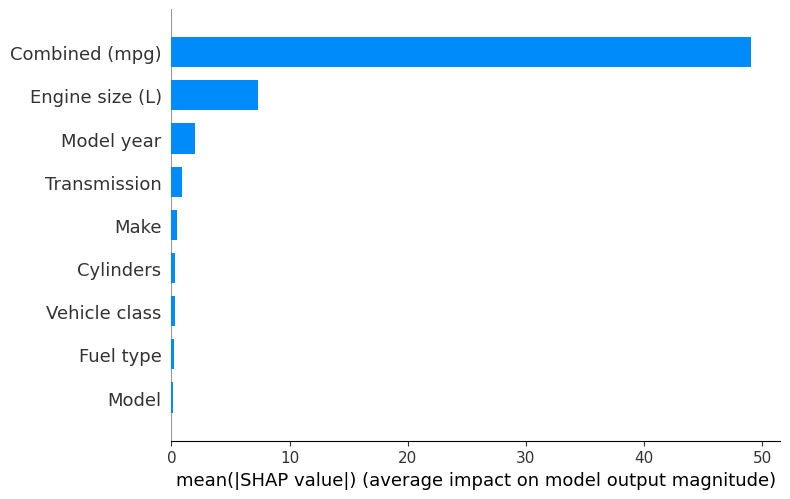

In [29]:
import shap
import pandas as pd

def examine_all_reason_codes(data, model):
    # Initialize the SHAP visualization
    shap.initjs()

    # Define the feature names as per your dataset
    feature_names = [
        'Combined (mpg)', 'Model year', 'Make', 'Model', 'Vehicle class',
        'Engine size (L)', 'Cylinders', 'Transmission', 'Fuel type'
    ]

    # Create a Tree explainer and calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data)

    # Convert data to DataFrame if it's not already
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data, columns=feature_names)

    # Summary plot for SHAP values
    shap.summary_plot(shap_values, data, plot_type="bar")

# Example of using this function, assuming 'best_model' is your trained GradientBoostingRegressor
# and 'X_test_scaled' is the prepared test data (already scaled and in the correct format)
examine_all_reason_codes(X_test_scaled, best_model)
